<a href="https://colab.research.google.com/github/brunafrade/face-recognition-pca-svm/blob/master/plot_eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Exemplo de vetores de faces: PCA e SVMs
=============================================


O objetivo deste exemplo é mostrar como um método não supervisionado e um supervisionado podem ser encadeados para uma melhor previsão.

Aqui utilizaremos um conjunto de dados menor e mais simples apenas para funs didáticos devido o tempo e tamanho dos datasets. Fique a vontade para explorar o dataset LFW da literatura  <http://vis-www.cs.umass.edu/lfw/>`__ que estão disponíveis com :func:`sklearn.datasets.fetch_lfw_people`


In [2]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


(400, 4096)


Vamos visualizar essas faces para ver com o que estamos trabalhando

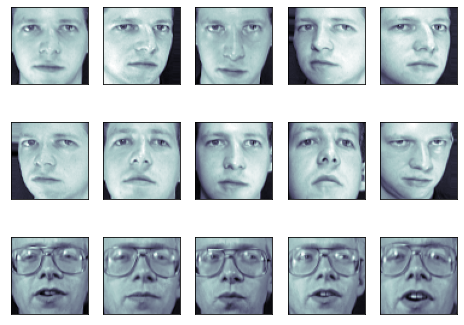

In [3]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)


Observe que essas faces já foram localizadas e redimensionadas para um
   tamanho comum. Esta é uma parte importante de pré-processamento para reconhecimento facial.

Vamos fazer uma divisão do nosso conjunto de dados em treino e teste:



In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

(300, 4096) (100, 4096)


Compressão de Features: Principal Component Analysis (PCA
-------------------------------------------

1850 dimensões é muito para SVM. Podemos usar o PCA para reduzir essas 1850
features a um tamanho gerenciável, mantendo a maioria das informações relevantes
do conjunto de dados.



In [10]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)


Uma parte interessante do PCA é que ele calcula a face "média", que
pode ser interessante visualizar:



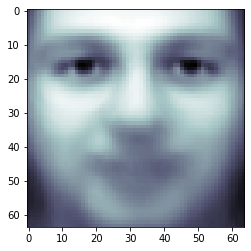

In [11]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



In [12]:
print(pca.components_.shape)

(150, 4096)



Também é interessante visualizar estes componentes principais:



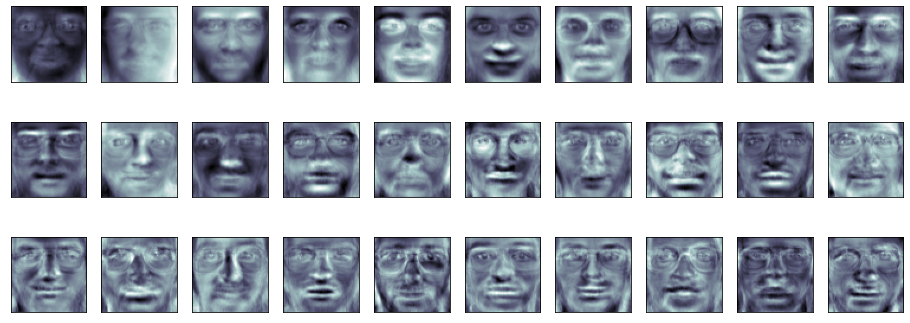

In [13]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

Os componentes ("eigenfaces") são ordenados por importância, do canto superior esquerdo ao canto inferior direito. Vemos que os primeiros componentes parecem cuidar principalmente das condições de iluminação; os componentes restantes extraem certas características de identificação: nariz, olhos, sobrancelhas, etc.

Com essa projeção calculada, podemos agora projetar nosso treinamento original e dados de teste na base do PCA:



In [14]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(300, 150)


In [15]:
print(X_test_pca.shape)

(100, 150)


Esses componentes projetados correspondem a uma combinação linear
de imagens de componentes de modo que a combinação se aproxime da
face original.

Fazendo o aprendizado: Support Vector Machines (SVM)
-------------------------------------------
Agora vamos realizar a classificação usando SVM no
conjunto de dados:



In [16]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


* Finalmente *, podemos avaliar o resultado da classificação. Nós usaremos primeiro alguns dos casos de teste no nosso modelo treinado:



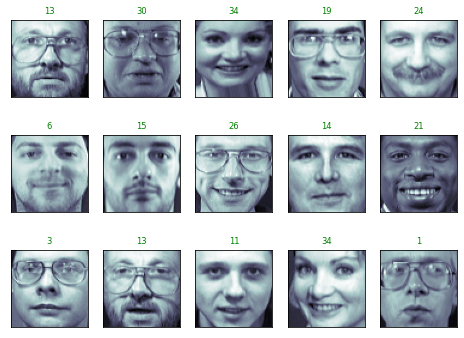

In [18]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('green' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

O classificador acertou todas as imagens de forma impressionante, dado a
simplicidade do seu modelo de aprendizagem! Usando um classificador linear que aprendeu utilizando apenas 150 features para representar uma imagem.

Novamente, podemos quantificar essa eficácia usando uma das várias métricas
do: mod: `sklearn.metrics`. Primeiro calcularemos precisão, recall e f1-score.



In [19]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      1.00      1.00         4
           2       0.50      1.00      0.67         2
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         4
           7       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         6
          19       1.00      1.00      1.00         4
          20       1.00    


Outra métrica interessante é a matriz de confusão, que indica com que frequência o modelo se confunde. A matriz de confusão de um classificador perfeito teria apenas valores diferentes de zero na diagonal, e zeros nas demais posições:



In [21]:
print(metrics.confusion_matrix(y_test, y_pred))

[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]


Pipelining
----------

Acima, usamos o PCA como uma etapa de pré-processamento antes de aplicar nosso classificador SVM. Conectar a saída de um extrator de features diretamente na entrada de um classificador é algo bastante usado em aprendizado de máquina; por esse motivo, o scikit-learn fornece um objeto Pipeline que automatiza esse processo. O problema acima pode ser refeito da seguinte forma:



In [ ]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_pred, y_test))
plt.show()

Observação:
----------------------------


Aqui, usamos "eigenfaces" do PCA como uma etapa de extração de features para
reconhecimento. A razão pela qual escolhemos isso é porque o PCA é um
técnica amplamente aplicável, que pode ser útil para uma ampla gama de
tipos de dados. Pesquisas na área de reconhecimento facial em particular,
no entanto, mostrou que outros métodos de extração de features mais específicos
podem ser muito mais eficazes. Veremos isso na aula sobre reconhecimento de faces no final do curso.

